<a href="https://colab.research.google.com/github/Fatima3660/Random-Forest-Classification-to-Detect-Network-Troajans/blob/main/RFclassifier_test%26train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import numpy as np #to convert dataset to numpy arrays
import pandas as pd #used in classification to create labelled data
from matplotlib import pyplot as plt
from sklearn import datasets #used to import datasets
from sklearn.model_selection import train_test_split #used to split the data into test and train dataset
from sklearn import preprocessing #used to encode the dataset column to convert categorical to numerical column
from sklearn.ensemble import RandomForestClassifier #the random forest classifier module
from sklearn.feature_selection import SelectFromModel #used to extract feature from the dataset
from sklearn.metrics import accuracy_score #used to calculate the accuracy value of the random forest detection
import seaborn as sns #used to create bar plots

# Import Dataset

In [ ]:
dataset = pd.read_csv("Trojan_Detection.csv", sep = r',', skipinitialspace = True)
print('The shape of the dataset : ', dataset.shape) #177482 instances, 86 attributes , dimensions of the dattaset
dataset.head() # preview the dataset

The shape of the dataset :  (177482, 86)


Unnamed: 0                                Flow ID    Source IP  \
0       73217    10.42.0.42-121.14.255.84-49975-80-6   10.42.0.42   
1       72089  172.217.6.226-10.42.0.42-443-49169-17   10.42.0.42   
2       96676       10.42.0.1-10.42.0.42-53-37749-17   10.42.0.42   
3       42891       10.42.0.1-10.42.0.42-53-41352-17   10.42.0.42   
4      169326  10.42.0.151-107.22.241.77-44353-443-6  10.42.0.151   

   Source Port Destination IP  Destination Port  Protocol  \
0        49975  121.14.255.84                80         6   
1        49169  172.217.6.226               443        17   
2        37749      10.42.0.1                53        17   
3        41352      10.42.0.1                53        17   
4        44353  107.22.241.77               443         6   

             Timestamp  Flow Duration  Total Fwd Packets  ...  \
0  17/07/2017 01:18:33       10743584                  4  ...   
1  17/07/2017 10:25:25         254217                  6  ...   
2  30/06/2017 07:16:12        1023244                  1  ...   
3  13/07/2017 03:48:44         286483                  1  ...   
4  05/07/2017 10:47:35       65633087                 12  ...   

   min_seg_size_forward  Active Mean  Active Std  Active Max  Active Min  \
0                    20          0.0         0.0         0.0         0.0   
1                    20          0.0         0.0         0.0         0.0   
2                    32          0.0         0.0         0.0         0.0   
3                    20          0.0         0.0         0.0         0.0   
4                    32     322594.0         0.0    322594.0    322594.0   

    Idle Mean  Idle Std    Idle Max    Idle Min   Class  
0         0.0       0.0         0.0         0.0  Trojan  
1         0.0       0.0         0.0         0.0  Trojan  
2         0.0       0.0         0.0         0.0  Benign  
3         0.0       0.0         0.0         0.0  Trojan  
4  60306983.0       0.0  60306983.0  60306983.0  Benign  

[5 rows x 86 columns]

In [ ]:
q1=dataset.quantile(0.25)
q3=dataset.quantile(0.75)
#using quartiles to find outliers
IQR=q3-q1
outliers = dataset[((dataset<(q1-1.5*IQR)) | (dataset>(q3+1.5*IQR)))]
print("number of outliers:" + str(len(outliers)))

<ipython-input-3-06fc1981e9d9>:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q1=dataset.quantile(0.25)
<ipython-input-3-06fc1981e9d9>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q3=dataset.quantile(0.75)
<ipython-input-3-06fc1981e9d9>:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = dataset[((dataset<(q1-1.5*IQR)) | (dataset>(q3+1.5*IQR)))]


number of outliers:177482


# Finding missing values
--> so this doesn't cause an error later on when ir comes to selecting features, plus you can feel them up with mean column value if its missing

In [ ]:
dataset.isnull().sum() #The above command returns total number of missing values in each column in the dataframe.

Unnamed: 0        0
Flow ID           0
Source IP         0
Source Port       0
Destination IP    0
                 ..
Idle Mean         0
Idle Std          0
Idle Max          0
Idle Min          0
Class             0
Length: 86, dtype: int64

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177482 entries, 0 to 177481
Data columns (total 86 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   177482 non-null  int64  
 1   Flow ID                      177482 non-null  object 
 2   Source IP                    177482 non-null  object 
 3   Source Port                  177482 non-null  int64  
 4   Destination IP               177482 non-null  object 
 5   Destination Port             177482 non-null  int64  
 6   Protocol                     177482 non-null  int64  
 7   Timestamp                    177482 non-null  object 
 8   Flow Duration                177482 non-null  int64  
 9   Total Fwd Packets            177482 non-null  int64  
 10  Total Backward Packets       177482 non-null  int64  
 11  Total Length of Fwd Packets  177482 non-null  float64
 12  Total Length of Bwd Packets  177482 non-null  float64
 13 

#Changing the values of target column to a boolean value

In [ ]:
dataset = dataset.replace("Trojan", 1)
dataset = dataset.replace("Benign", 0)
dataset = dataset.drop(['Unnamed: 0'], axis=1) # don't want it as a feature
dataset = dataset.drop(['Timestamp'], axis=1) # don't want it as a feature

# Encoding
--> Changing the values to numerical values than using categorical data as this wont be able to processed by sciki learn and creating features with numerical data is much easier than categorical

--> Encde the object data type to float

In [ ]:
#Label Encoding
number = preprocessing.LabelEncoder()
dataset["Flow ID"] = number.fit_transform(dataset["Flow ID"])#Convert categorical to numerical

#Modify the values by removing the decimal point and then combinig them together to a string of integers
dataset['Source IP'] = dataset['Source IP'].apply(lambda x: ''.join(x.split('.')))
dataset['Destination IP'] = dataset['Destination IP'].apply(lambda x: ''.join(x.split('.')))

#converting to interger type using .astype()
dataset['Flow ID'] = dataset['Flow ID'].astype(int)
dataset['Source IP'] = dataset['Source IP'].astype(int)
dataset['Destination IP'] = dataset['Destination IP'].astype(int)

dataset.head()

Flow ID  Source IP  Source Port  Destination IP  Destination Port  \
0    46111    1042042        49975      1211425584                80   
1    74905    1042042        49169      1722176226               443   
2     9217    1042042        37749          104201                53   
3    10418    1042042        41352          104201                53   
4    20763   10420151        44353      1072224177               443   

   Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0         6       10743584                  4                       4   
1        17         254217                  6                       7   
2        17        1023244                  1                       1   
3        17         286483                  1                       1   
4         6       65633087                 12                      10   

   Total Length of Fwd Packets  ...  min_seg_size_forward  Active Mean  \
0                        372.0  ...                    20          0.0   
1                       3191.0  ...                    20          0.0   
2                         30.0  ...                    32          0.0   
3                         40.0  ...                    20          0.0   
4                        767.0  ...                    32     322594.0   

   Active Std  Active Max  Active Min   Idle Mean  Idle Std    Idle Max  \
0         0.0         0.0         0.0         0.0       0.0         0.0   
1         0.0         0.0         0.0         0.0       0.0         0.0   
2         0.0         0.0         0.0         0.0       0.0         0.0   
3         0.0         0.0         0.0         0.0       0.0         0.0   
4         0.0    322594.0    322594.0  60306983.0       0.0  60306983.0   

     Idle Min  Class  
0         0.0      1  
1         0.0      1  
2         0.0      0  
3         0.0      1  
4  60306983.0      0  

[5 rows x 84 columns]

In [ ]:
print(dataset.columns) # columns of the dataset

Index(['Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet 

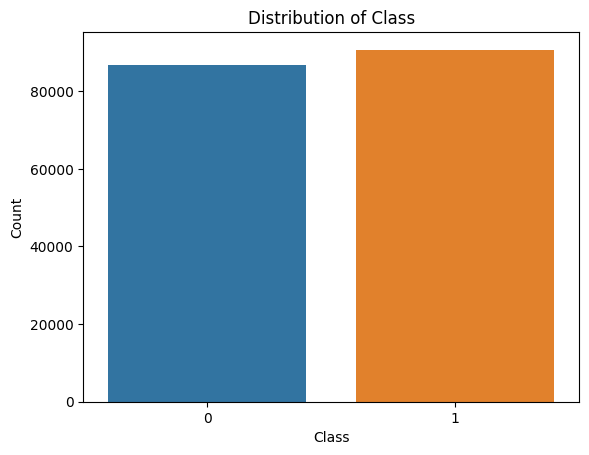

In [ ]:
sns.countplot(data=dataset, x='Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Class')
plt.show()
#0 = benign 1= trojan

# View summary of dataset
-->Find what datatypes each column is

In [ ]:
dataset.info() # float64(45), int64(36), object(5), Class is the target column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177482 entries, 0 to 177481
Data columns (total 84 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Flow ID                      177482 non-null  int64  
 1   Source IP                    177482 non-null  int64  
 2   Source Port                  177482 non-null  int64  
 3   Destination IP               177482 non-null  int64  
 4   Destination Port             177482 non-null  int64  
 5   Protocol                     177482 non-null  int64  
 6   Flow Duration                177482 non-null  int64  
 7   Total Fwd Packets            177482 non-null  int64  
 8   Total Backward Packets       177482 non-null  int64  
 9   Total Length of Fwd Packets  177482 non-null  float64
 10  Total Length of Bwd Packets  177482 non-null  float64
 11  Fwd Packet Length Max        177482 non-null  float64
 12  Fwd Packet Length Min        177482 non-null  float64
 13 

# Defining X and y and Splitting data
--> the .drop function drops the column Class which is the target column, axis =1 shows that it is a column we want to remove than a axis =0 which is a row

--> this now results into a new dataframe that has all the feature columns without the target column there so it won't be used when it comes to finding features later

--> now we can use X dataframe to train the model as only feature columns are needed to make predictions

--> y now stores the target column. When it comes to training our machine learning model X is only used for to learna d make predictions and target column y is used to calculate the loss or error of the models predictiions during training

--> feature selectin method only detects the correlation between the features and the targets that whihch feature can give the highest information gain or reduce in entropy.

--> Numpy arrays are more memory efficient so they can process faster than pandas dataframes which is important with large datasets plus nummpyarray is the expected formaat that sciki learn needs as an input



In [ ]:
#X = feature columns, y=target column
#axis =1 drop column, axis = 0 drop row
X = dataset.drop("Class", axis=1) #doesn't use the target colulmn for feature extraction, since this already makes it classified
y = dataset["Class"] #The target column to be used for predictions and testing

#converting dataframe to numpy arrays
X = np.array(X)
y = np.array(y)

## Create Training And Test Data
Randomly splitting the data into test and train data

--> test_size: he proportion of the dataset to include in the testing set. In this case, we're using 0.2 (or 20%) to indicate that we want 20% of the data to be held out for testing, and the remaining 80% will be used for training.

-->random_state: The seed value for the random number generator used by scikit-learn. Setting this to a fixed value (like 42) ensures that the data is split in the same way every time the code is run. This can be helpful for reproducibility and debugging purposes.

X_train: The input features for the training set.
X_test: The input features for the testing set.
y_train: The target variable (or labels) for the training set.
y_test: The target variable (or labels) for the testing set.

The value 42 is often used as an arbitrary seed value because it has become a bit of a convention in the data science community. However, any integer value can be used as a seed value.

When random_state is set to 0, the random number generator is initialized with a different seed value, and different random values are generated compared to when the seed value is set to 42.

In the context of the train_test_split() function, the random_state parameter ensures that the same random split of the data into training and test sets is performed each time the code is run, as long as the same seed value is used.

So, in summary, random_state is used to control the randomness in scikit-learn, and the specific value used (such as 42 or 0) is not important as long as it is consistent.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#test_size = 0.2 means training = 80% and testing = 20%

print('Training: ', X_train.shape, X_test.shape)
print('Testing: ', y_train.shape, y_test.shape)

Training:  (141985, 83) (35497, 83)
Testing:  (141985,) (35497,)


# Feature importance
The Gini importance measures the total reduction of the Gini impurity index in the decision trees that make up the random forest when a particular feature is used for splitting the data. Features that lead to a larger reduction in impurity are considered more important.

compute the feature importances on the training set only, as this reflects the importance of features in predicting unseen dat


sorted_indices gives us the indices of the features in descending order of importance. We can then use these indices to plot the feature importances in descending order, as well as to obtain the feature names in descending order of importance.

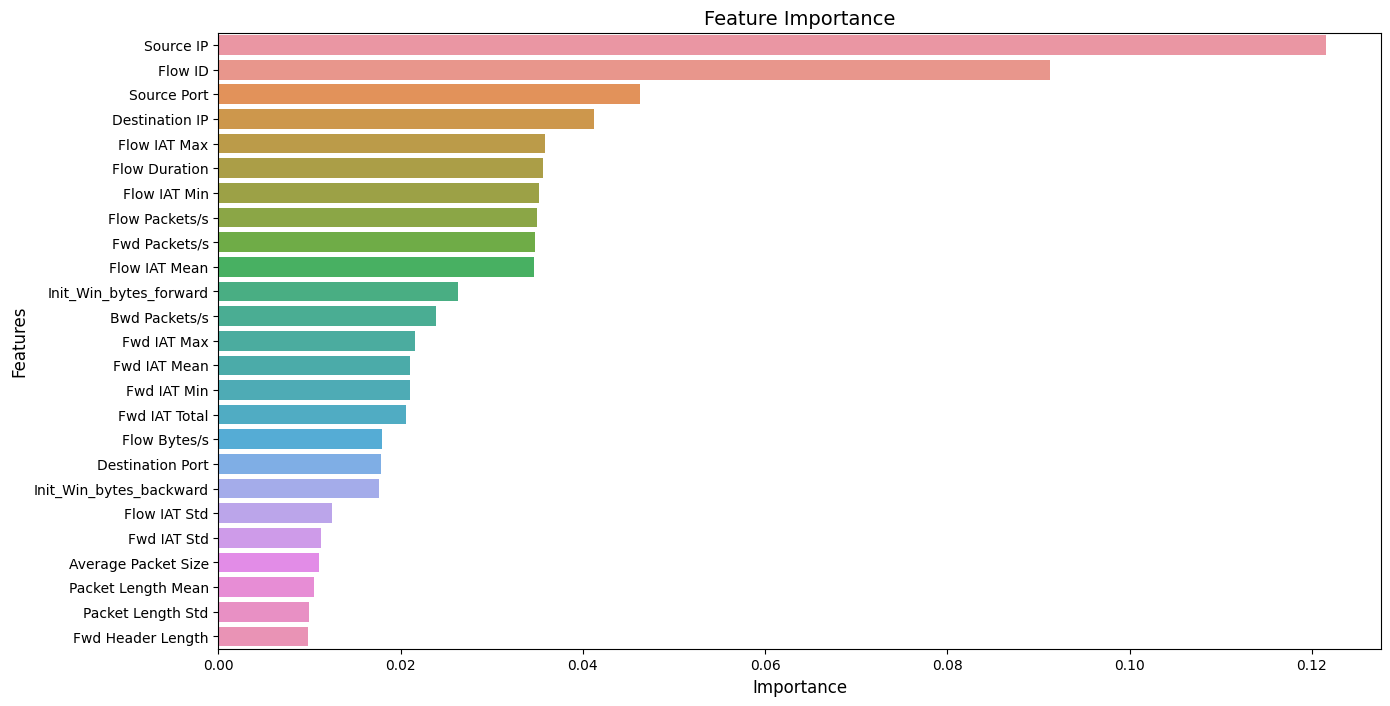

In [ ]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)#fit the training data in the model to find the important features

important_features = classifier.feature_importances_ #get the feature importanaces
feature_index = np.argsort(important_features)[::-1][:25]## Get the indices that would sort the importances in descending order

#plotting the features
plt.figure(figsize=(15, 8))  # Adjust figure size# Add padding argument
sns.barplot(x=important_features[feature_index], y=dataset.columns[feature_index])

plt.xlabel('Importance', fontsize=12)  # Increase x-axis font size
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance', fontsize=14)
plt.show()

# Reducing overfitting

In [ ]:
X_train_reduced = X_train[:, feature_index]
X_test_reduced = X_test[:, feature_index]

In [ ]:
classifier.fit(X_train_reduced, y_train)

RandomForestClassifier(random_state=42)

# Test data into the classifiers
X_test is the test feature data
After training the classifier on the training data using rfc.fit(X_train, y_train), you can use the trained classifier to predict the target values for the test data by calling rfc.predict(X_test). The predicted target values will be returned as a numpy array, which you can compare against the true target values y_test to evaluate the performance of the classifier.


ValueError: X has 20 features, but RandomForestClassifier is expecting 83 features as input. to fix this error the best way was to reduce  the fatures size in bothe the x train and x test data

In [ ]:
y_pred = classifier.predict(X_test_reduced) #use the classifier to classify data in X train as trojan or benign

In [ ]:
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1']) # labell the confusion matrix

# Print the labeled confusion matrix
cm_table = tabulate(cm_df, headers='keys', tablefmt='psql')
print("Confusion Matrix:")
print(cm_table)

Confusion Matrix:
+----------+---------------+---------------+
|          |   Predicted 0 |   Predicted 1 |
|----------+---------------+---------------|
| Actual 0 |         15043 |          2394 |
| Actual 1 |          3971 |         14089 |
+----------+---------------+---------------+


In [ ]:
#Collect the values from the confusion matrix
TP = cm[1, 1]  # True Positive
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative
TN = cm[0, 0]  # True Negative

#Calculate the valles
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
Precision = TP / (TP + FP)
Accuracy = (TP + TN) / (TP + TN + FP + FN)
Recall = TP / (TP + FN)
F1_Score = 2 * (Precision * TPR) / (Precision + TPR)

In [ ]:
print('True positive rate: ', TPR)
print('False positive rate: ', FPR)
print('Precision:', Precision)
print('Accuracy:', Accuracy)
print('Recall:', Recall)
print('F1_Score:', F1_Score)

True positive rate:  0.7801218161683278
False positive rate:  0.13729425933360095
Precision: 0.854759449129406
Accuracy: 0.8206890723159703
Recall: 0.7801218161683278
F1_Score: 0.8157369076223836


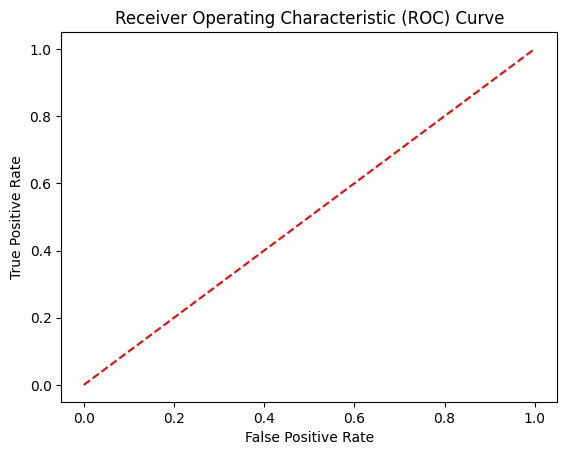

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

plt.plot(FPR, TPR)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()